
## Tree Bagging vs Random Forests

#### Andres Gonzalez
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

Decision trees tend to produce overfit models. To address this shortcoming two algoithms have been proposed, Tree Bagging and Random Forest. These aglgorithms belong to a group of algorithms named ensemble algorithms (i.e. a collection of multiple machine learning algorithms), in the case of the mentioned algorithms they use a collection of Decision Trees. In the case of Tree Bagging Bootstrap Aggregation (resampling with replacement of the training set to generate new training sets) is employed to reduced the overfit of the model. On the other hand, Random Forest in addition to Bootstrap Aggregation introduce randomness in the trainig of the model by randomly selecting n features from the m training features (n<m) for each split test. In this project I will show whether or not tree decorrelation (Random Forests) improve the accuracy over Tree Bagging. 

For that purpose I generated a random regression dataset with 10 predictor feature and 1 response feature. I divided the data into training/testing set for model tunning using 5-fold cross-validation and a set aside 30% of the original dataset for testing of the tuned model on unseen data. First, I tuned the Tree Bagging model and used the tuned paramters for Random Forest and varied the number max features (i.e., the maximum number of features used for splitting a leaf). Finally, I used the unseen dataset to evaluate the accuracy of the trained models. 

### 1. Import Packages
In here export all the required libraries 

In [19]:
import numpy as np                                        # for working with data and model arrays
import pandas as pd                                       # for working with dataframes
import time as t                                          # for time functions
# import os                                                 # for operative system operations 
import matplotlib.pyplot as plt                           # for plotting purposes
import seaborn as sn                                      # for plotting purposes 
from sklearn.ensemble import BaggingRegressor             # Tree bagging function for regression
from sklearn.tree import DecisionTreeRegressor            # decision tree fucntion for regression
from sklearn.ensemble import RandomForestRegressor        # Random forest function for regression 
from sklearn.datasets import make_regression, make_friedman1              # generator of random regression problem
from sklearn.model_selection import train_test_split      # function to split data into train and test sets
from sklearn import metrics                               # model goodness assessment library
from sklearn.model_selection import cross_val_score         # cross validation methods

### 2. Data generation
I created a random regression dataset of 10 predictor features, 1 response feature, and 1000 samples using the function make_regression.

In [20]:
n_feat = 10 # the number of desired features 
random_dataset =  make_regression(n_samples = 1000, n_features = n_feat, bias = 0.0, noise = 0.0, random_state = 0) # generates a random regression problem
feat_labels = ["feature_{}".format(x+1) for x in range(n_feat) ] # predictor features names generator
feat_labels.append("response_feature") # response feature name
random_dataset = np.append(random_dataset[0], np.expand_dims(random_dataset[1], axis =1), axis = 1) # concatenate both response and predictor features in one array
random_dataset = pd.DataFrame(random_dataset, columns = feat_labels) # convert the features array into a pandas dataframe
random_dataset.describe().transpose() # Data set overview

,count,mean,std,min,25%,50%,75%,max
feature_1,1000.0,-0.033721,0.991383,-2.838198,-0.712177,-0.002728,0.616244,3.170975
feature_2,1000.0,-0.046649,1.008979,-3.069207,-0.715520,-0.029406,0.638403,3.427539
feature_3,1000.0,-0.038313,0.999860,-3.740101,-0.681679,-0.030903,0.633722,3.306574
feature_4,1000.0,0.058781,0.955035,-3.392300,-0.554495,0.053152,0.666122,2.979976
feature_5,1000.0,-0.019207,1.016933,-2.810668,-0.764144,-0.016157,0.673593,3.211847
feature_6,1000.0,-0.053810,0.974906,-2.758928,-0.732754,-0.064157,0.599920,2.925250
feature_7,1000.0,0.021288,0.982688,-3.017878,-0.624513,-0.006251,0.689010,2.865204
feature_8,1000.0,-0.016396,1.005830,-3.116857,-0.758677,-0.048301,0.656469,3.801660
feature_9,1000.0,-0.008957,0.946799,-2.994613,-0.653531,-0.005379,0.637535,3.094980
feature_10,1000.0,-0.047353,0.990051,-2.841551,-0.709835,-0.080175,0.636260,2.657273


In the two cells below I added gaussian noise to the response feature to increase the effect of model overfit. 

In [85]:
noise = np.random.normal(0.0, 150, random_dataset.shape[0]) # Random noise generation

In [86]:
random_dataset["response_feature"] = random_dataset["response_feature"] + noise # adding random noise to the random dataset
random_dataset.describe().transpose() #overview of the random dataset + noise

,count,mean,std,min,25%,50%,75%,max
feature_1,1000.0,-0.033721,0.991383,-2.838198,-0.712177,-0.002728,0.616244,3.170975
feature_2,1000.0,-0.046649,1.008979,-3.069207,-0.715520,-0.029406,0.638403,3.427539
feature_3,1000.0,-0.038313,0.999860,-3.740101,-0.681679,-0.030903,0.633722,3.306574
feature_4,1000.0,0.058781,0.955035,-3.392300,-0.554495,0.053152,0.666122,2.979976
feature_5,1000.0,-0.019207,1.016933,-2.810668,-0.764144,-0.016157,0.673593,3.211847
feature_6,1000.0,-0.053810,0.974906,-2.758928,-0.732754,-0.064157,0.599920,2.925250
feature_7,1000.0,0.021288,0.982688,-3.017878,-0.624513,-0.006251,0.689010,2.865204
feature_8,1000.0,-0.016396,1.005830,-3.116857,-0.758677,-0.048301,0.656469,3.801660
feature_9,1000.0,-0.008957,0.946799,-2.994613,-0.653531,-0.005379,0.637535,3.094980
feature_10,1000.0,-0.047353,0.990051,-2.841551,-0.709835,-0.080175,0.636260,2.657273


### 3. Data Visualization
In here I plotted the pair plot of all the predictor features and the response features.

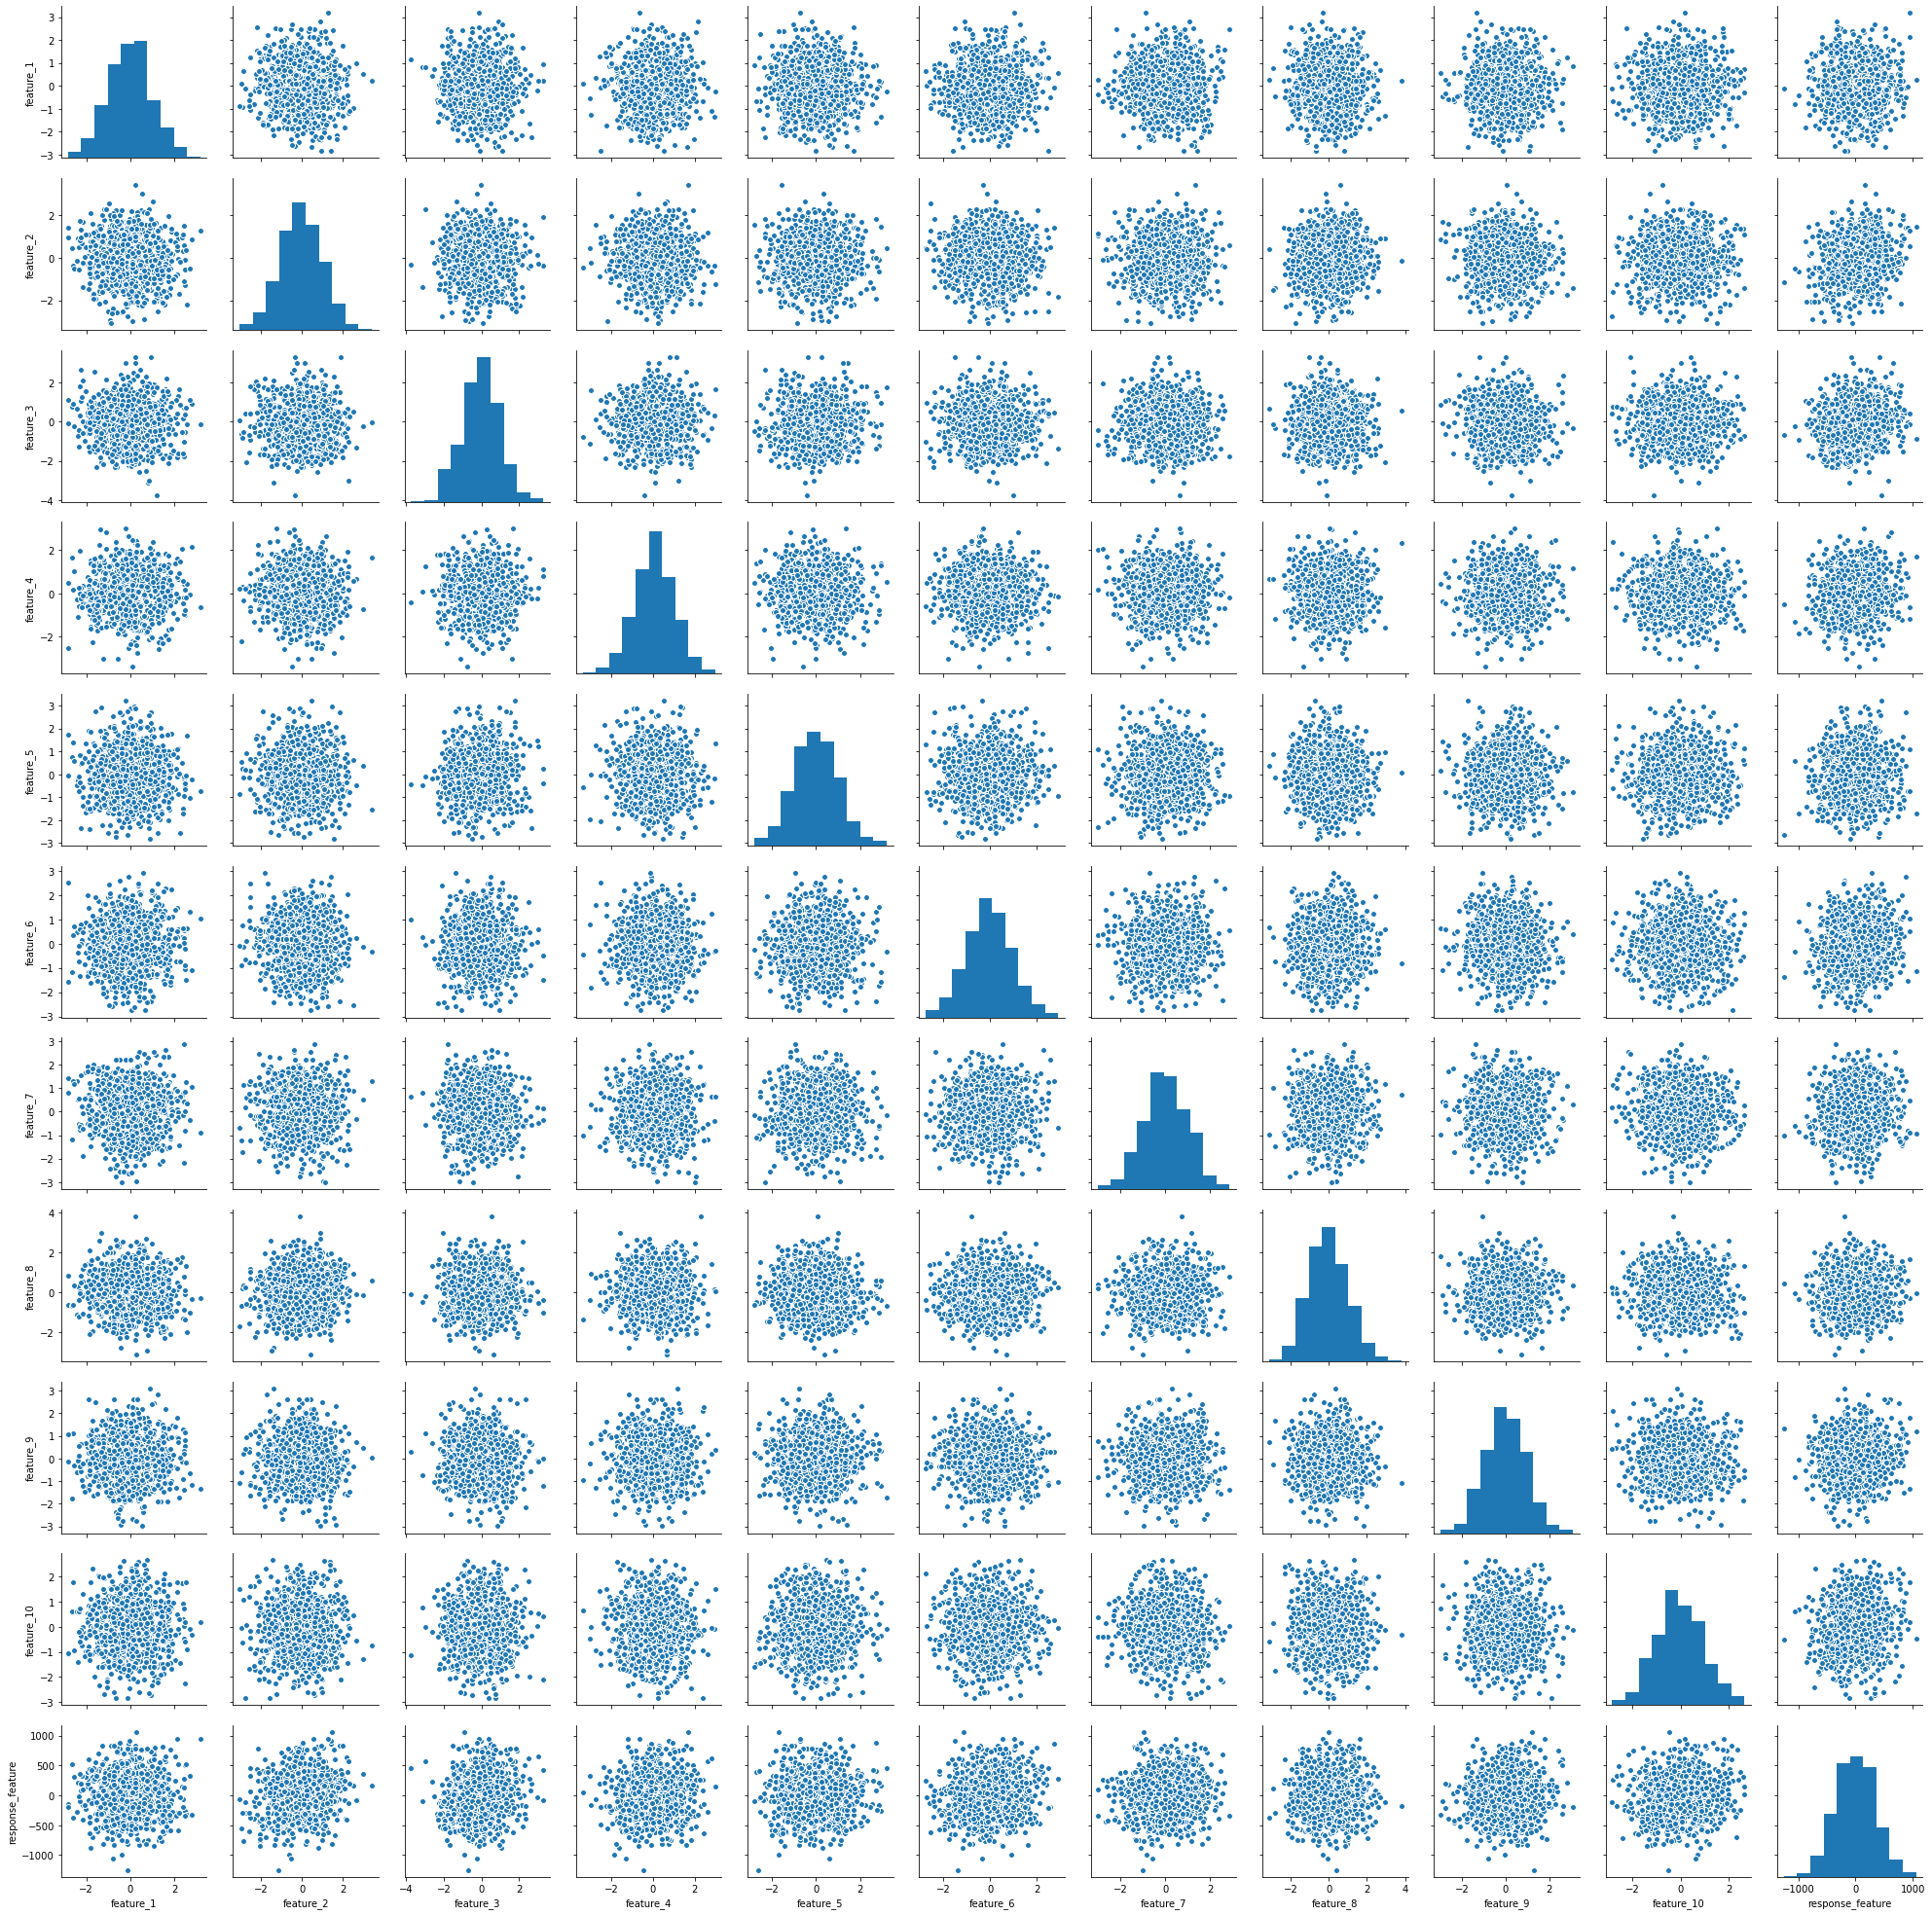

In [87]:
sn.pairplot(random_dataset) # Seabron pairplot 
plt.show() # matplotlib show figure

### 4. Data Splitting
In this step I split my dateset in two, one set for trainining/testing the model using the k-fold cross-validation approach, and the other set to test tuned model with unseen data. I will use 700 samples for tuning the model and 300 samples for testing the model with unseen data.

In [88]:
kfold_set = random_dataset.sample(frac=0.70, random_state = 0) #random selection of 700 samples from the random dataset
unseen_set = random_dataset.drop(kfold_set.index) # the reamaining 300 samples from the random dataset

### 5. Tree Bagging for Increasing number of trees
First, I tuned the number of tress for bagging exploring a paramter space from 1 to 200 trees and using the mean square error as a goodness metric. I used 5-fold cross validation for this purpose. At this step the rest of the parameters of the decision tree model are left as default.The use of Bootstrap Aggregation, allows for tuning the model with "out of bag samples" (i.e., samples not taken in the boostrap realization of the training data set). However, I decided to tune the model using the k-fold cross validation approach instead. 
#### This step takes about 10 - 12  minutes in a desktop computer with 8 cores and 32gb of RAM 

In [89]:
num_estimators = np.linspace(1,200,200).astype(int) # array with the number of trees to be used for tuning
mse_score = [] # empty list to store the mean squared error
t0 = t.time()
for i in range(num_estimators.shape[0]):
    tree = DecisionTreeRegressor(random_state=0) # decision tree instantiation
    reg_bagging = BaggingRegressor(base_estimator = tree , n_estimators=num_estimators[i], random_state=0, n_jobs = -1) # tree bagging instantiation
    score = cross_val_score(estimator = reg_bagging, X = kfold_set.iloc[:,0:10].values, y = kfold_set.iloc[:,10].values, cv = 5, n_jobs = -1, scoring = "neg_mean_squared_error") # mean square error calculation
    mse_score.append(abs(score.mean())) # appending mean square error to the list mse_score
print("For loop took {:.2f} minutes".format((t.time()-t0)*(1/60))) # time to run the loop

For loop took 11.07 minutes


### 6. Tree Bagging - Plot of Mean Squared Error vs Number of Trees after 5-fold cross validation
In this step I plot the average mean squared error of the 5-fold cross-validation fro increasing number of trees.

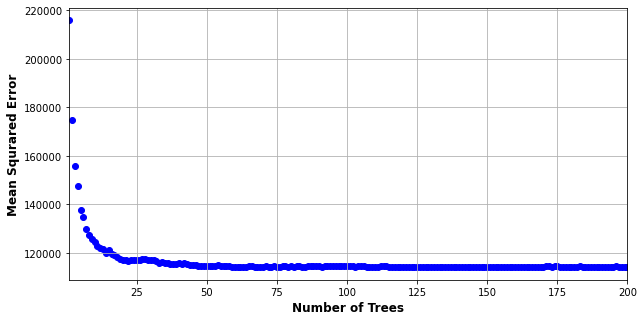

In [90]:
fig0, ax00 = plt.subplots(1,1, figsize = (10,5))
ax00.scatter(num_estimators, mse_score, color = 'b')
ax00.set_xlabel("Number of Trees", fontsize = 12, fontweight = 'bold')
ax00.set_ylabel("Mean Squrared Error", fontsize = 12, fontweight = 'bold')
ax00.grid(True)
ax00.set_xlim(1,200)
plt.show()

In [93]:
print("Minimum mean squared error achieved", np.min(mse_score))
tuned_n_trees = num_estimators[np.where(mse_score == np.min(mse_score))[0][0]] 
print("Minimum mean squared error achieved for", tuned_n_trees, "trees")

Minimum mean squared error achieved 113895.42119994227
Minimum mean squared error achieved for 139 trees


### 7. Tree Bagging for Increasing number max depth
Second, I tuned the max depth of the trees for bagging exploring a paramter space from 1 to 100 max depth and 72 trees as found in the preivous step. I continued using the mean square error as a goodness metric. I used 5-fold cross validation for this purpose.
#### This step takes about 5-7 minutes in a desktop computer with 8 cores and 32gb of RAM memory

In [94]:
max_depths = np.linspace(1,100,100).astype(int)  # array with the number of max depths to be used for tuning
mse_score_md = [] # empty list to store the mean squared error
t0 = t.time()
for i in range(max_depths.shape[0]):
    tree = DecisionTreeRegressor(max_depth = max_depths[i], random_state=0) # decision tree instantiation
    reg_bagging = BaggingRegressor(base_estimator = tree , n_estimators = tuned_n_trees, random_state=0) # tree bagging instantiation
    score_md = cross_val_score(estimator = reg_bagging, X = kfold_set.iloc[:,0:10].values, y = kfold_set.iloc[:,10].values, cv = 5, n_jobs = -1, scoring = "neg_mean_squared_error") # mean square error calculation
    mse_score_md.append(abs(score_md.mean())) # appending mean square error to the list mse_score
print("For loop took {:.2f} minutes".format((t.time()-t0)*(1/60))) # time to run the loop

For loop took 5.71 minutes


### 8. Tree Bagging - Plot of Mean Squared Error vs Max Depth after 5-fold cross validation
In this step I plot the average mean squared error of the 5-fold cross-validation for increasing max depth

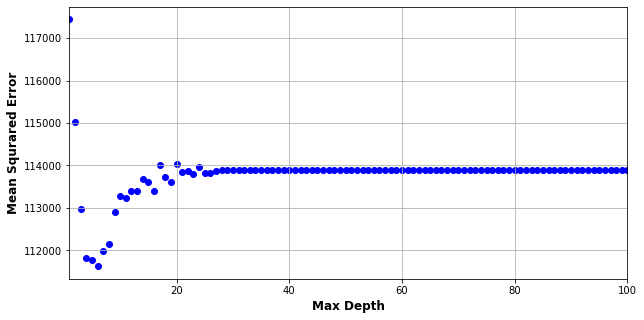

In [95]:
fig1, ax10 = plt.subplots(1,1, figsize = (10,5))
ax10.scatter(max_depths, mse_score_md, color = 'b')
ax10.set_xlabel("Max Depth", fontsize = 12, fontweight = 'bold')
ax10.set_ylabel("Mean Squrared Error", fontsize = 12, fontweight = 'bold')
ax10.grid(True)
ax10.set_xlim(1,100)
plt.show()

In [96]:
print("Minimum mean squared error achieved", np.min(mse_score_md))
tuned_maxdepth = num_estimators[np.where(mse_score_md == np.min(mse_score_md))[0][0]] 
print("Minimum mean squared error achieved for", tuned_maxdepth, "max depth")

Minimum mean squared error achieved 111619.84612720774
Minimum mean squared error achieved for 6 max depth


So far I tuned the number of trees and the max depth for Tree bagging. The main difference between Tree Bagging and Random Forest is the random selection of the features used in splitting each leaf in Random Forest. As such, if we select all n features in the Random Forest algorithm and use the same hyperparameters as in Tree Bagging, we would achieve the same prediction model. So, I used the same hyperparametes as in Tree Bagging, but I varied the number of features selected in the Random Forest to compared it against Tree Bagging

### 9. Random Forest for decreasing Max Features
In this step I evaluated the Random Forest algorithm using the tuned paramters I found in step 6 and 8, and varied the number max features used for splitting each leaf. 

In [97]:
max_features_num = [10,9,8,7,6,5,4,3,2,1] # list with the number of max number of features to be used 
mse_score_mf_rd = [] # empty list to store the mean squared error
t0 = t.time()
for j in range(len(max_features_num)):
    regr_random = RandomForestRegressor(n_estimators=tuned_n_trees, random_state=0, max_features = max_features_num[j], max_depth = tuned_maxdepth, n_jobs=-1) # random forest instantiation
    score_mf_rd = cross_val_score(estimator = regr_random, X = kfold_set.iloc[:,0:10].values, y = kfold_set.iloc[:,10].values, cv = 5, n_jobs = -1, scoring = "neg_mean_squared_error") # mean square error calculation
    mse_score_mf_rd.append(abs(score_mf_rd.mean())) # appending mean square error to the list mse_score
    print(mse_score_mf_rd[j], max_features_num[j])
print("For loop took {:.2f} minutes".format((t.time()-t0)*(1/60))) # time to run the loop

111855.81180692426 10
111953.15048068883 9
112421.23490245416 8
111387.84396761113 7
112011.33048477353 6
111692.22451946019 5
111612.08489886734 4
111852.6432211652 3
111869.83637832684 2
111457.1315033134 1
For loop took 0.53 minutes


### 10. Random Forest - Plot of Mean Squared Error vs Number of Features for 5-fold cross validation
In this step I plot the average mean squared error of the 5-fold cross-validation for decreasing max features.

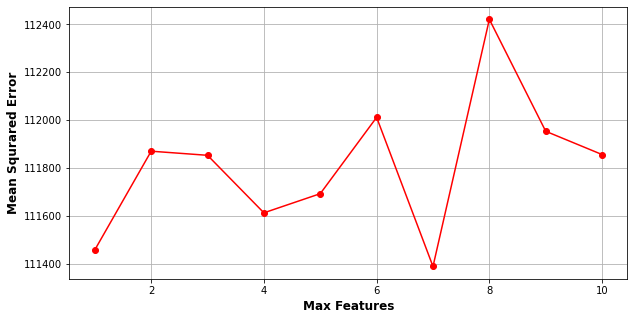

In [98]:
fig2, ax20 = plt.subplots(1,1, figsize = (10,5))
ax20.plot(max_features_num, mse_score_mf_rd, marker =  "o", color = 'r')
ax20.set_xlabel("Max Features", fontsize = 12, fontweight = "bold")
ax20.set_ylabel("Mean Squrared Error", fontsize = 12, fontweight = "bold")
ax20.grid(True)
plt.show()

### 11 Tuned models and model accuracy with unseen data
In this step I use the tuned hyperparameters to train the inal Tree Bagging model and the Random Forest model. In the case of the Random Forest model I varied the number of max features to show dependency of accuracy with respect to the number of max features.

### 11.a Tree Bagging

In [99]:
final_tree = DecisionTreeRegressor(max_depth = tuned_maxdepth, random_state=0) # decision treee instantiation
final_reg_bagging = BaggingRegressor(base_estimator = final_tree , n_estimators = tuned_n_trees, random_state=0).fit(kfold_set.iloc[:,0:10].values, kfold_set.iloc[:,10].values) # tree bagging instantiation
final_bagging_pred = final_reg_bagging.predict(unseen_set.iloc[:,0:10]) # prediction on unseen data
MSE_final_bagging = metrics.mean_squared_error(unseen_set.iloc[:,10], final_bagging_pred) # mean square error calculation
print("Mean Squared Error in Unseen Data", MSE_final_bagging) 

Mean Squared Error in Unseen Data 112472.67732440375


### 11.b Random Forest

In [100]:
max_features_num = [10,9,8,7,6,5,4,3,2,1] # list with the number of max number of features to be used
final_MSE_random = [] # empty list to store the mean squared error
for j in range(len(max_features_num)):
    final_regr_random = RandomForestRegressor(n_estimators=tuned_n_trees, random_state=0, max_features = max_features_num[j], max_depth = tuned_maxdepth, n_jobs=-1).fit(kfold_set.iloc[:,0:10].values, kfold_set.iloc[:,10].values) # random forest instantiation
    final_regr_random_pred = final_regr_random.predict(unseen_set.iloc[:,0:10]) # prediction on unseen data
    final_MSE_random.append(metrics.mean_squared_error(unseen_set.iloc[:,10], final_regr_random_pred))
    print("Mean Squared error in Unseen Data ",final_MSE_random[j], "for", max_features_num[j], "Max Features") # appending mean square error to the list final_MSE_random

Mean Squared error in Unseen Data  112448.44286581069 for 10 Max Features
Mean Squared error in Unseen Data  112236.38171316996 for 9 Max Features
Mean Squared error in Unseen Data  112622.93722453075 for 8 Max Features
Mean Squared error in Unseen Data  113152.93256821265 for 7 Max Features
Mean Squared error in Unseen Data  111074.93208694081 for 6 Max Features
Mean Squared error in Unseen Data  112226.46005763253 for 5 Max Features
Mean Squared error in Unseen Data  110672.79666126677 for 4 Max Features
Mean Squared error in Unseen Data  111313.31595795455 for 3 Max Features
Mean Squared error in Unseen Data  112982.10775536323 for 2 Max Features
Mean Squared error in Unseen Data  113541.87215701326 for 1 Max Features


### 12. MSE Tree Bagging vs Random Forest - Unseen Data
Graphical comparison of the mean squared error on unseen data for varying number of max features in Random Forests and Tree-bagging. In both algorithms I used the previouly tunded hyperparameters.

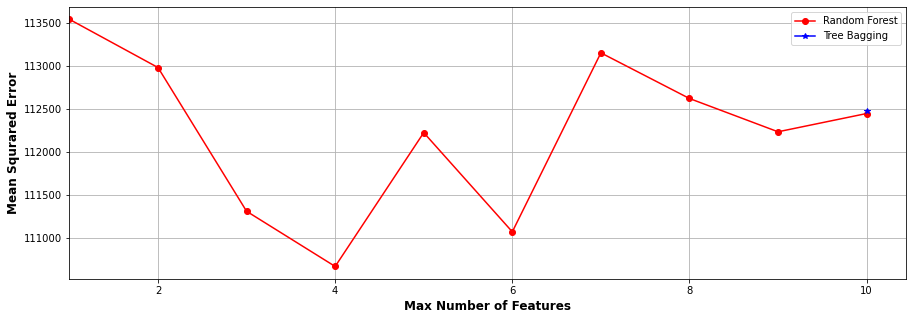

In [101]:
fig3, ax30 = plt.subplots(1,1, figsize = (15,5))
ax30.plot(max_features_num, final_MSE_random, marker = "o", color = 'r', label = "Random Forest")
ax30.plot(10,MSE_final_bagging, marker = "*", label = "Tree Bagging", color = "b")
ax30.set_xlabel("Max Number of Features", fontsize = 12, fontweight = "bold")
ax30.set_ylabel("Mean Squrared Error", fontsize = 12, fontweight = "bold")
ax30.set_xlim(1,)
ax30.grid(True)
ax30.legend()
plt.show()

### 13. Final Remarks 
Tree decorrelation in Random Forest (achieved by randomly selecting m features m < n total features for leaf splitting) slightly improves the accuracy in the generated random regression problem dataset (10 predictor features, 1 response feature + Gaussian noise, and 1000 samples) when compared to Tree Bagging. Results showed that for 9,6,5,4, and 3 max features the Random Forest model results in a higher accuracy than Tree Bagging. For the rest number of Max features Tree Bagging results in a higher accuracy than Random Forests, for this particular datset. The obtained show the effect of tree decorrelation for improving the model accuracy when using Random Forests. However, testing of other datasets is required to fully verify the effect of Tree Decorrelation. 